In [1]:
import os
# os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=1'
os.environ["XLA_FLAGS"] = "--xla_gpu_force_compilation_parallelism=1"

CUDA_VISIBLE_DEVICES=0,1
import jax

# PyMC for Bayesian Inference
import pymc as pm
import arviz as az
import bambi as bmb
print(f"Running on PyMC v{pm.__version__}")

# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# Scikit-learn utilities
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# Matplotlib and seaborn for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.4


In [2]:
df = pd.read_csv('data/HI_Small_Trans_Standardised.csv')
df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,Timestamp,AmountPaid,AmountReceived,IsLaundering
0,6530,6530,8,8,12,12,5,2022-09-01 00:20:00,3697.34,3697.34,0
1,358174,176809,109,0,12,12,3,2022-09-01 00:20:00,0.01,0.01,0
2,358476,358476,110,110,12,12,5,2022-09-01 00:00:00,14675.57,14675.57,0
3,74640,74640,10,10,12,12,5,2022-09-01 00:02:00,2806.97,2806.97,0
4,6538,6538,8,8,12,12,5,2022-09-01 00:06:00,36682.97,36682.97,0


In [3]:
# additional feature pre-processing

# Split Timestamp column into MM, DD, HH etc. (Ignore dt columns with constant values - Year, Month, Second)
# df['Timestamp'] = pd.to_datetime(df['Timestamp'])
# # df['Year'] = df['Timestamp'].dt.year
# # df['Month'] = df['Timestamp'].dt.month
# df['Day'] = df['Timestamp'].dt.day
# df['Hour'] = df['Timestamp'].dt.hour
# df['Minute'] = df['Timestamp'].dt.minute
# df['Second'] = df['Timestamp'].dt.second
df = df.drop(columns=['Timestamp'])

# Benford's law: Add first leading digit from both "Amount Paid" & "Amount Received" columns
def get_first_digit(figure:float) -> int:
    exception_set = ('0','.','e','-')
    for char in str(figure):
        if char not in exception_set:
            return int(char)

df['LDAmountPaid'] = df.apply(lambda x: get_first_digit(x['AmountPaid']), axis=1)
df['LDAmountReceived'] = df.apply(lambda x: get_first_digit(x['AmountReceived']), axis=1)

df.head()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,IsLaundering,LDAmountPaid,LDAmountReceived
0,6530,6530,8,8,12,12,5,3697.34,3697.34,0,3,3
1,358174,176809,109,0,12,12,3,0.01,0.01,0,1,1
2,358476,358476,110,110,12,12,5,14675.57,14675.57,0,1,1
3,74640,74640,10,10,12,12,5,2806.97,2806.97,0,2,2
4,6538,6538,8,8,12,12,5,36682.97,36682.97,0,3,3


<Axes: xlabel='LDAmountReceived', ylabel='count'>

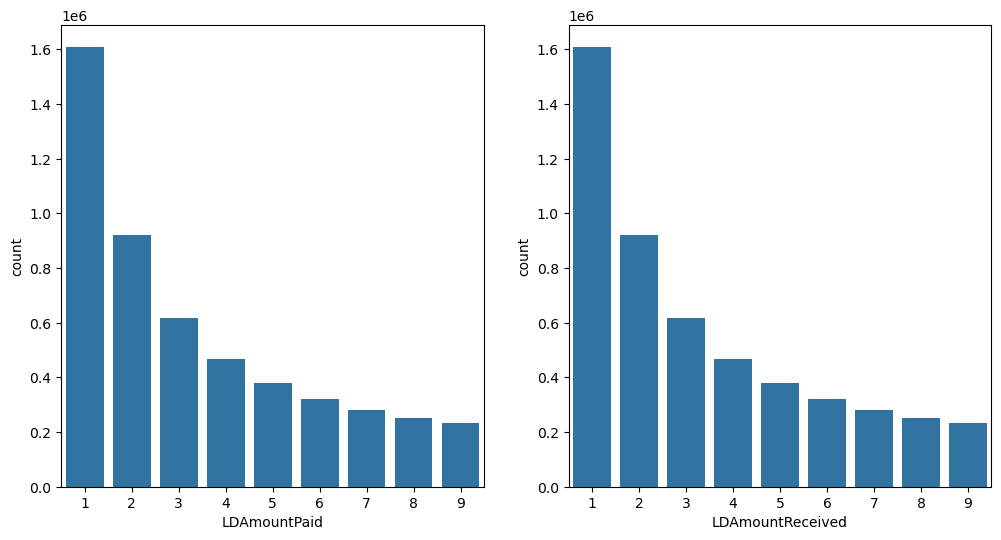

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.countplot(x="LDAmountPaid", data=df, ax=axes[0])
sns.countplot(x="LDAmountReceived", data=df, ax=axes[1])

In [5]:
features = df.drop(columns='IsLaundering')
labels = df['IsLaundering']
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42, stratify=labels)

In [6]:
y_train.value_counts()

IsLaundering
0    4058534
1       4142
Name: count, dtype: int64

In [7]:
y_test.value_counts()

IsLaundering
0    1014634
1       1035
Name: count, dtype: int64

In [8]:
# Create version of the training data with labels
X_with_labels = X_train.copy()
X_with_labels['IsLaundering'] = y_train
X_with_labels.describe()

,FromAccount,ToAccount,FromBank,ToBank,ReceivingCurrency,PaymentCurrency,PaymentFormat,AmountPaid,AmountReceived,LDAmountPaid,LDAmountReceived,IsLaundering
count,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06,4.062676e+06
mean,2.382306e+05,2.124135e+05,1.947946e+03,2.637890e+03,8.383044e+00,8.413508e+00,3.042607e+00,4.591495e+06,6.075187e+06,3.358283e+00,3.357843e+00,1.019525e-03
std,1.633146e+05,1.443503e+05,3.563786e+03,3.029517e+03,4.120737e+00,4.120447e+00,1.489445e+00,9.100063e+08,1.059474e+09,2.459928e+00,2.459516e+00,3.191373e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e-06,1.000000e-06,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.044800e+05,9.607500e+04,3.300000e+01,5.400000e+02,4.000000e+00,4.000000e+00,3.000000e+00,1.846800e+02,1.835600e+02,1.000000e+00,1.000000e+00,0.000000e+00
50%,2.046320e+05,1.928830e+05,5.960000e+02,8.360000e+02,1.000000e+01,1.000000e+01,3.000000e+00,1.413650e+03,1.410400e+03,3.000000e+00,3.000000e+00,0.000000e+00
75%,3.622202e+05,2.898940e+05,9.710000e+02,6.111000e+03,1.200000e+01,1.200000e+01,4.000000e+00,1.230018e+04,1.234698e+04,5.000000e+00,5.000000e+00,0.000000e+00
max,5.150860e+05,5.150870e+05,3.046900e+04,3.046400e+04,1.400000e+01,1.400000e+01,6.000000e+00,1.046302e+12,1.046302e+12,9.000000e+00,9.000000e+00,1.000000e+00


### Bayesian Logistic Regression

#### Model 1 - Naive Model

In [9]:
# Build up a formula
formula = [' %s + ' % variable for variable in X_train.columns]
formula.insert(0, 'IsLaundering ~ ')
formula = ' '.join(''.join(formula).split(' ')[:-2])
formula

'IsLaundering ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  LDAmountPaid +  LDAmountReceived'

In [10]:
# Building of Bayesian Logistic Regression model
model = bmb.Model(formula, X_with_labels, family="bernoulli")
model

       Formula: IsLaundering ~  FromAccount +  ToAccount +  FromBank +  ToBank +  ReceivingCurrency +  PaymentCurrency +  PaymentFormat +  AmountPaid +  AmountReceived +  LDAmountPaid +  LDAmountReceived
        Family: bernoulli
          Link: p = logit
  Observations: 4062676
        Priors: 
    target = p
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 11.874)
            FromAccount ~ Normal(mu: 0.0, sigma: 0.0)
            ToAccount ~ Normal(mu: 0.0, sigma: 0.0)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0007)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6067)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.6067)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.6785)
            AmountPaid ~ Normal(mu: 0.0, sigma: 0.0)
            AmountReceived ~ Normal(mu: 0.0, sigma: 0.0)
            LDAmountPaid ~ Normal(mu: 0.0, sigma: 1.0163)
            LDAmountReceived ~ Normal(mu:

Sampling: [AmountPaid, AmountReceived, FromAccount, FromBank, Intercept, LDAmountPaid, LDAmountReceived, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToAccount, ToBank]


array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'LDAmountPaid'}>,
        <Axes: title={'center': 'LDAmountReceived'}>]], dtype=object)

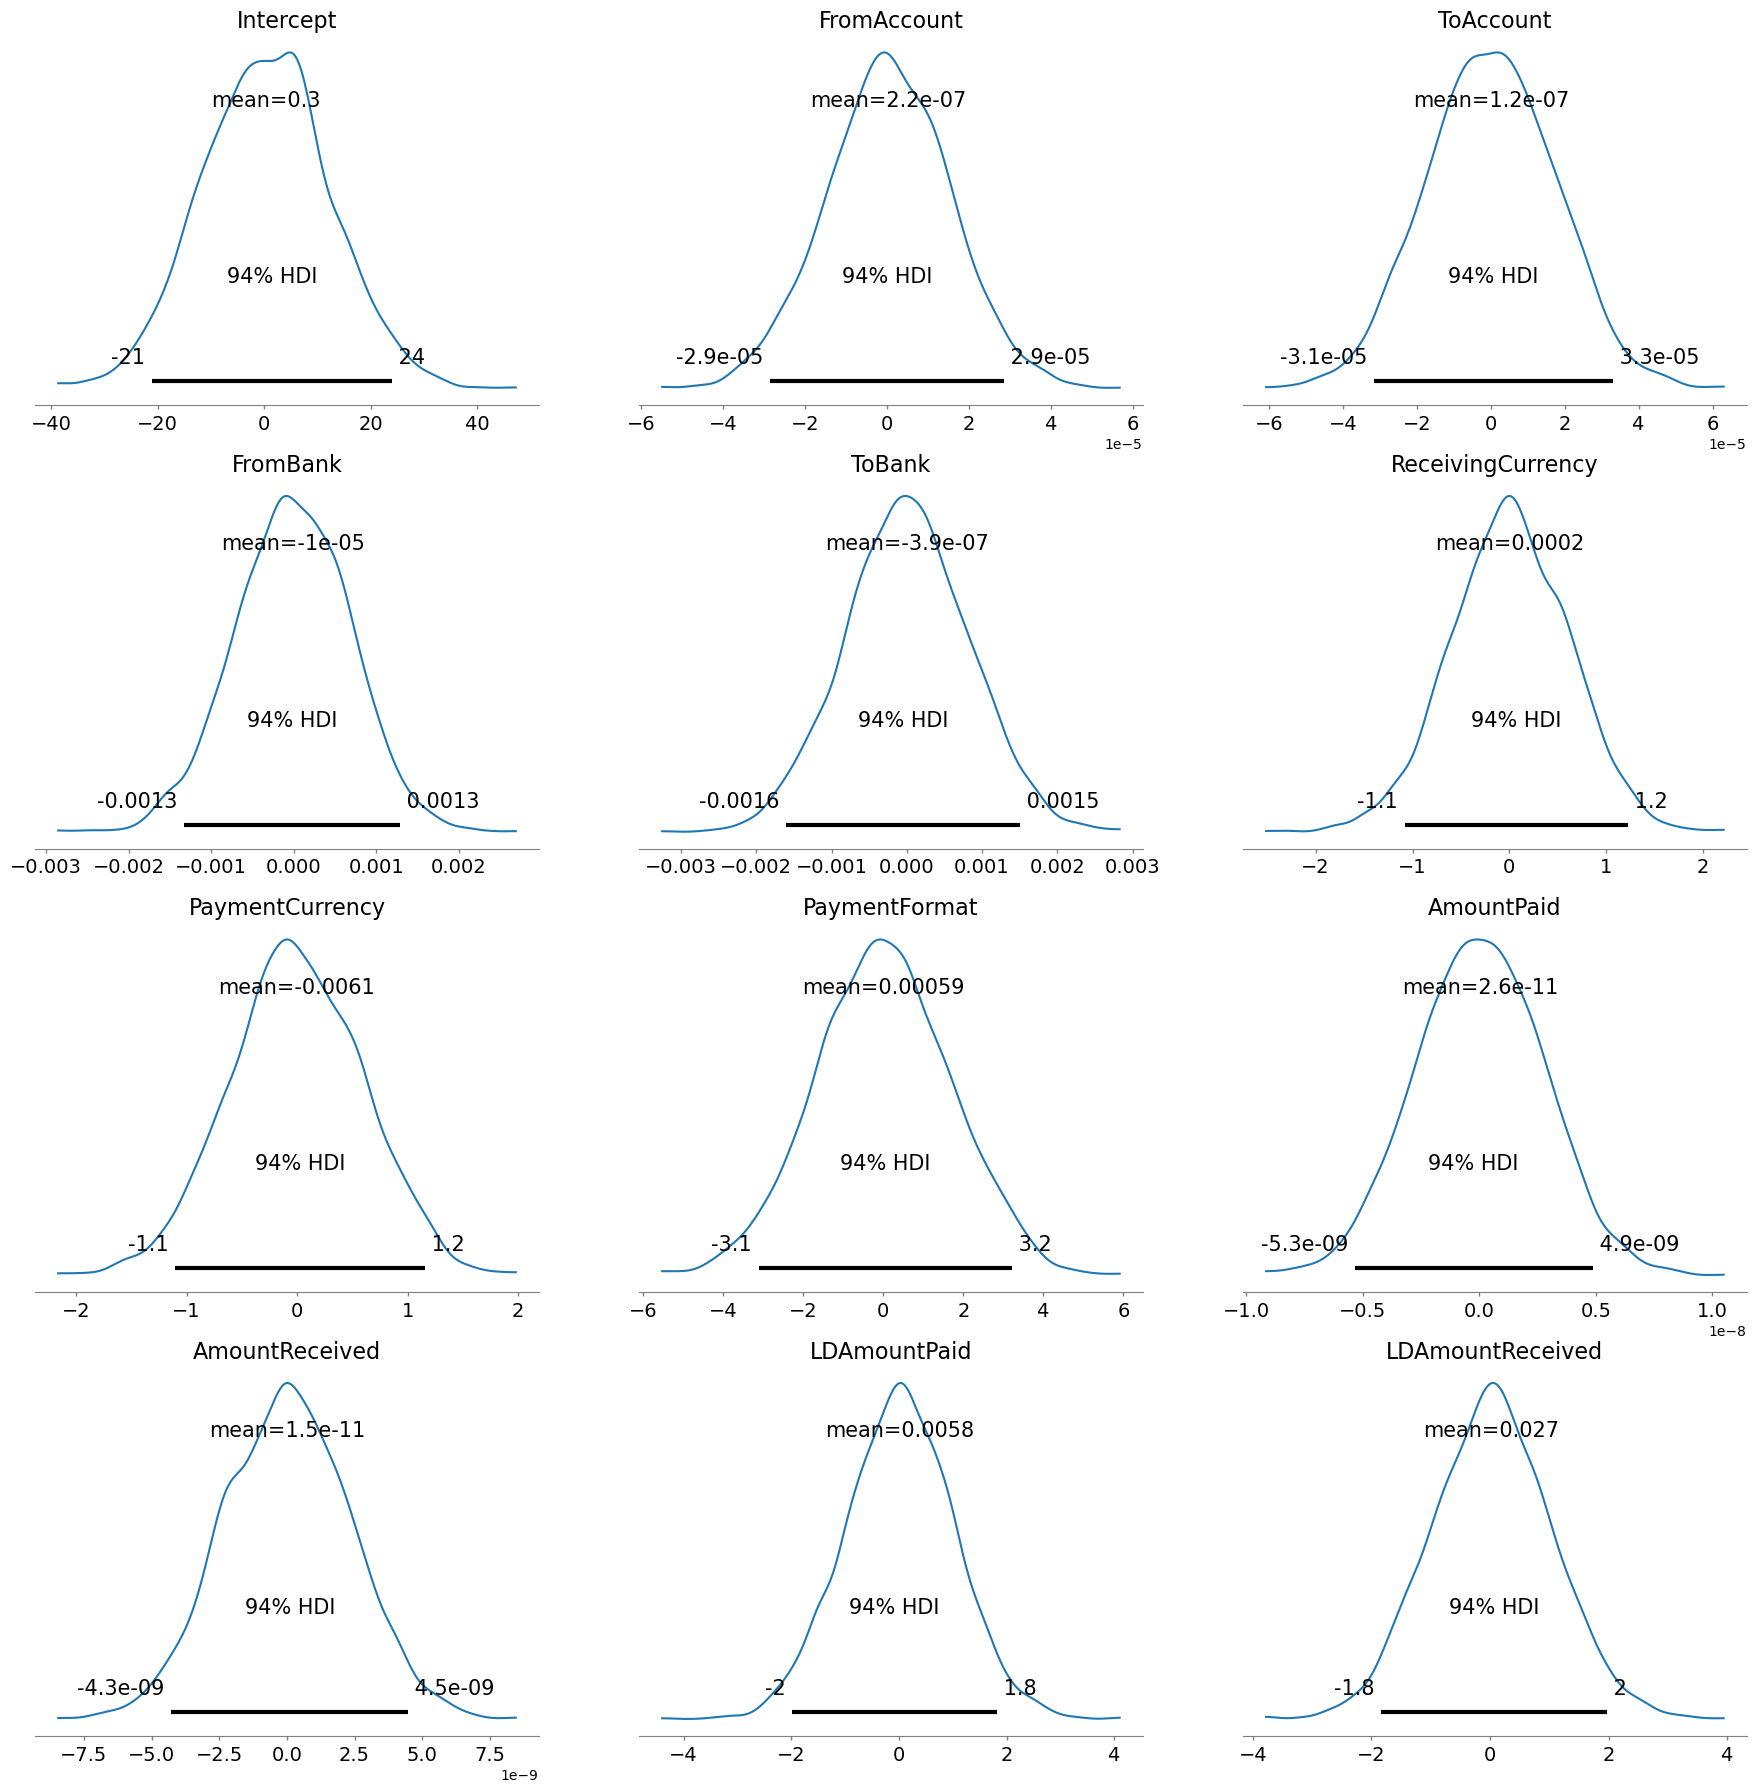

In [11]:
# Plot marginal priors of the built model
model.build()
model.plot_priors()

In [12]:
# fit the model
# inference methods: 'numpyro_nuts', 'nuts_blackjax'
results = model.fit(draws=1000, chains=2, inference_method='nuts_blackjax', idata_kwargs={"log_likelihood": True})

Modeling the probability that IsLaundering==1
/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling...
2024-04-13 13:46:24.321513: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Compilation time = 0:00:06.784736
Sampling...


ValueError: compiling computation that requires 2 logical devices, but only 1 XLA devices are available (num_replicas=2)

In [ ]:
results

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'FromAccount'}>],
       [<Axes: title={'center': 'ToAccount'}>,
        <Axes: title={'center': 'ToAccount'}>],
       [<Axes: title={'center': 'FromBank'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ToBank'}>],
       [<Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>],
       [<Axes: title={'center': 'PaymentCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'PaymentFormat'}>],
       [<Axes: title={'center': 'AmountPaid'}>,
        <Axes: title={'center': 'AmountPaid'}>],
       [<Axes: title={'center': 'AmountReceived'}>,
        <Axes: title={'center': 'AmountReceived'}>],
      

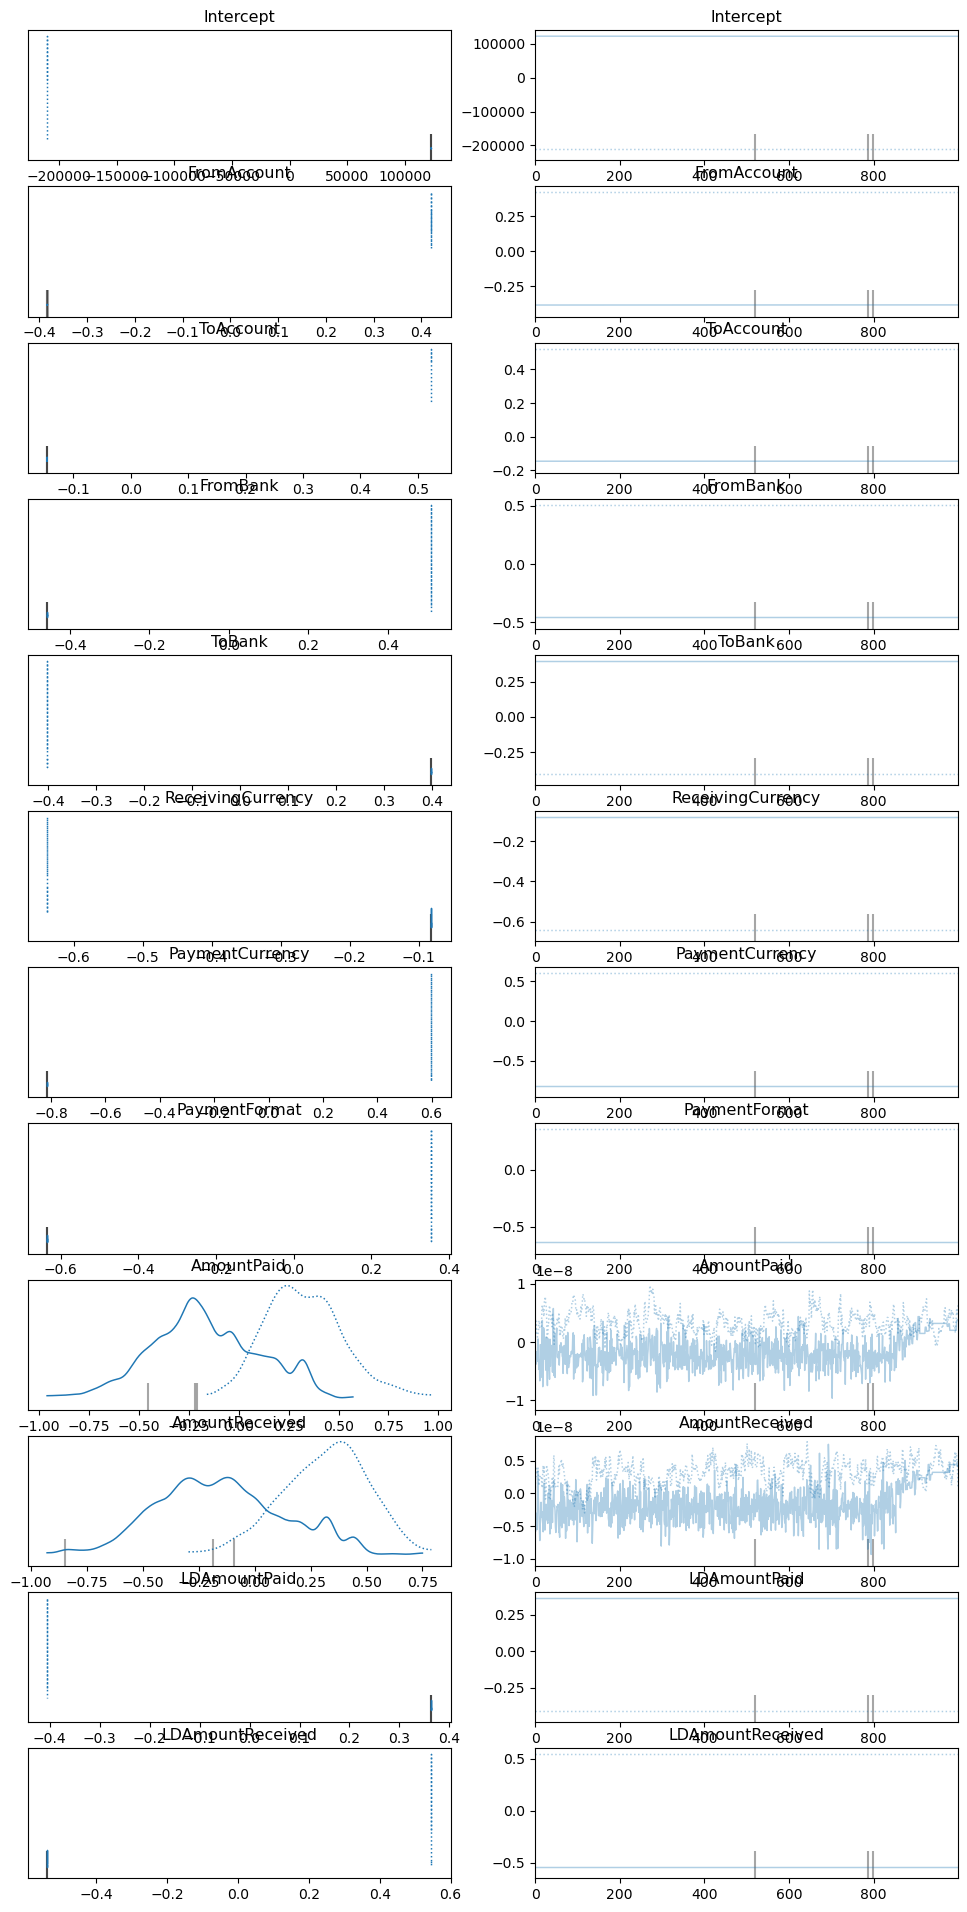

In [ ]:
# traceplots and density estimates for the posteriors
az.plot_trace(results, compact=True)

In [ ]:
# summary of the posteriors
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-43841.638,166412.081,-210212.443,122615.001,117199.481,99145.434,2.0,11.0,3.03
FromAccount,0.019,0.402,-0.384,0.421,0.283,0.240,2.0,11.0,3.04
ToAccount,0.189,0.335,-0.146,0.523,0.236,0.199,2.0,11.0,3.04
FromBank,0.026,0.484,-0.458,0.510,0.341,0.288,3.0,13.0,2.18
ToBank,-0.002,0.401,-0.403,0.399,0.282,0.239,2.0,15.0,2.54
ReceivingCurrency,-0.360,0.279,-0.639,-0.081,0.196,0.166,3.0,22.0,2.26
PaymentCurrency,-0.108,0.707,-0.814,0.599,0.498,0.421,3.0,12.0,2.23
PaymentFormat,-0.140,0.495,-0.635,0.355,0.349,0.295,3.0,16.0,2.20
AmountPaid,0.000,0.000,-0.000,0.000,0.000,0.000,4.0,57.0,1.54
AmountReceived,0.000,0.000,-0.000,0.000,0.000,0.000,4.0,69.0,1.51


<Axes: >

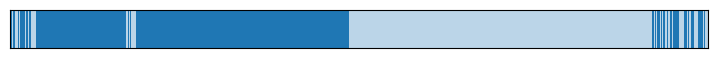

In [ ]:
model.predict(results, kind="pps")
az.plot_separation(results, y='IsLaundering', figsize=(9,0.5)) # separation plot to assess model performance

#### Model 2

In [ ]:
formula = '''IsLaundering ~  0 + FromAccount +  ToAccount 
                            +  FromBank +  ToBank 
                            +  ReceivingCurrency +  PaymentCurrency 
                            +  PaymentFormat +  AmountPaid +  AmountReceived 
                            +  LDAmountPaid +  LDAmountReceived
'''

model2 = bmb.Model(formula, X_with_labels, family="bernoulli")
model2

       Formula: IsLaundering ~  0 + FromAccount +  ToAccount 
                            +  FromBank +  ToBank 
                            +  ReceivingCurrency +  PaymentCurrency 
                            +  PaymentFormat +  AmountPaid +  AmountReceived 
                            +  LDAmountPaid +  LDAmountReceived

        Family: bernoulli
          Link: p = logit
  Observations: 10256
        Priors: 
    target = p
        Common-level effects
            FromAccount ~ Normal(mu: 0.0, sigma: 0.0)
            ToAccount ~ Normal(mu: 0.0, sigma: 0.0)
            FromBank ~ Normal(mu: 0.0, sigma: 0.0008)
            ToBank ~ Normal(mu: 0.0, sigma: 0.0009)
            ReceivingCurrency ~ Normal(mu: 0.0, sigma: 0.6203)
            PaymentCurrency ~ Normal(mu: 0.0, sigma: 0.6202)
            PaymentFormat ~ Normal(mu: 0.0, sigma: 1.3508)
            AmountPaid ~ Normal(mu: 0.0, sigma: 0.0)
            AmountReceived ~ Normal(mu: 0.0, sigma: 0.0)
            LDAmountPaid ~ Normal(m

Sampling: [AmountPaid, AmountReceived, FromAccount, FromBank, LDAmountPaid, LDAmountReceived, PaymentCurrency, PaymentFormat, ReceivingCurrency, ToAccount, ToBank]


array([[<Axes: title={'center': 'FromAccount'}>,
        <Axes: title={'center': 'ToAccount'}>,
        <Axes: title={'center': 'FromBank'}>],
       [<Axes: title={'center': 'ToBank'}>,
        <Axes: title={'center': 'ReceivingCurrency'}>,
        <Axes: title={'center': 'PaymentCurrency'}>],
       [<Axes: title={'center': 'PaymentFormat'}>,
        <Axes: title={'center': 'AmountPaid'}>,
        <Axes: title={'center': 'AmountReceived'}>],
       [<Axes: title={'center': 'LDAmountPaid'}>,
        <Axes: title={'center': 'LDAmountReceived'}>, <Axes: >]],
      dtype=object)

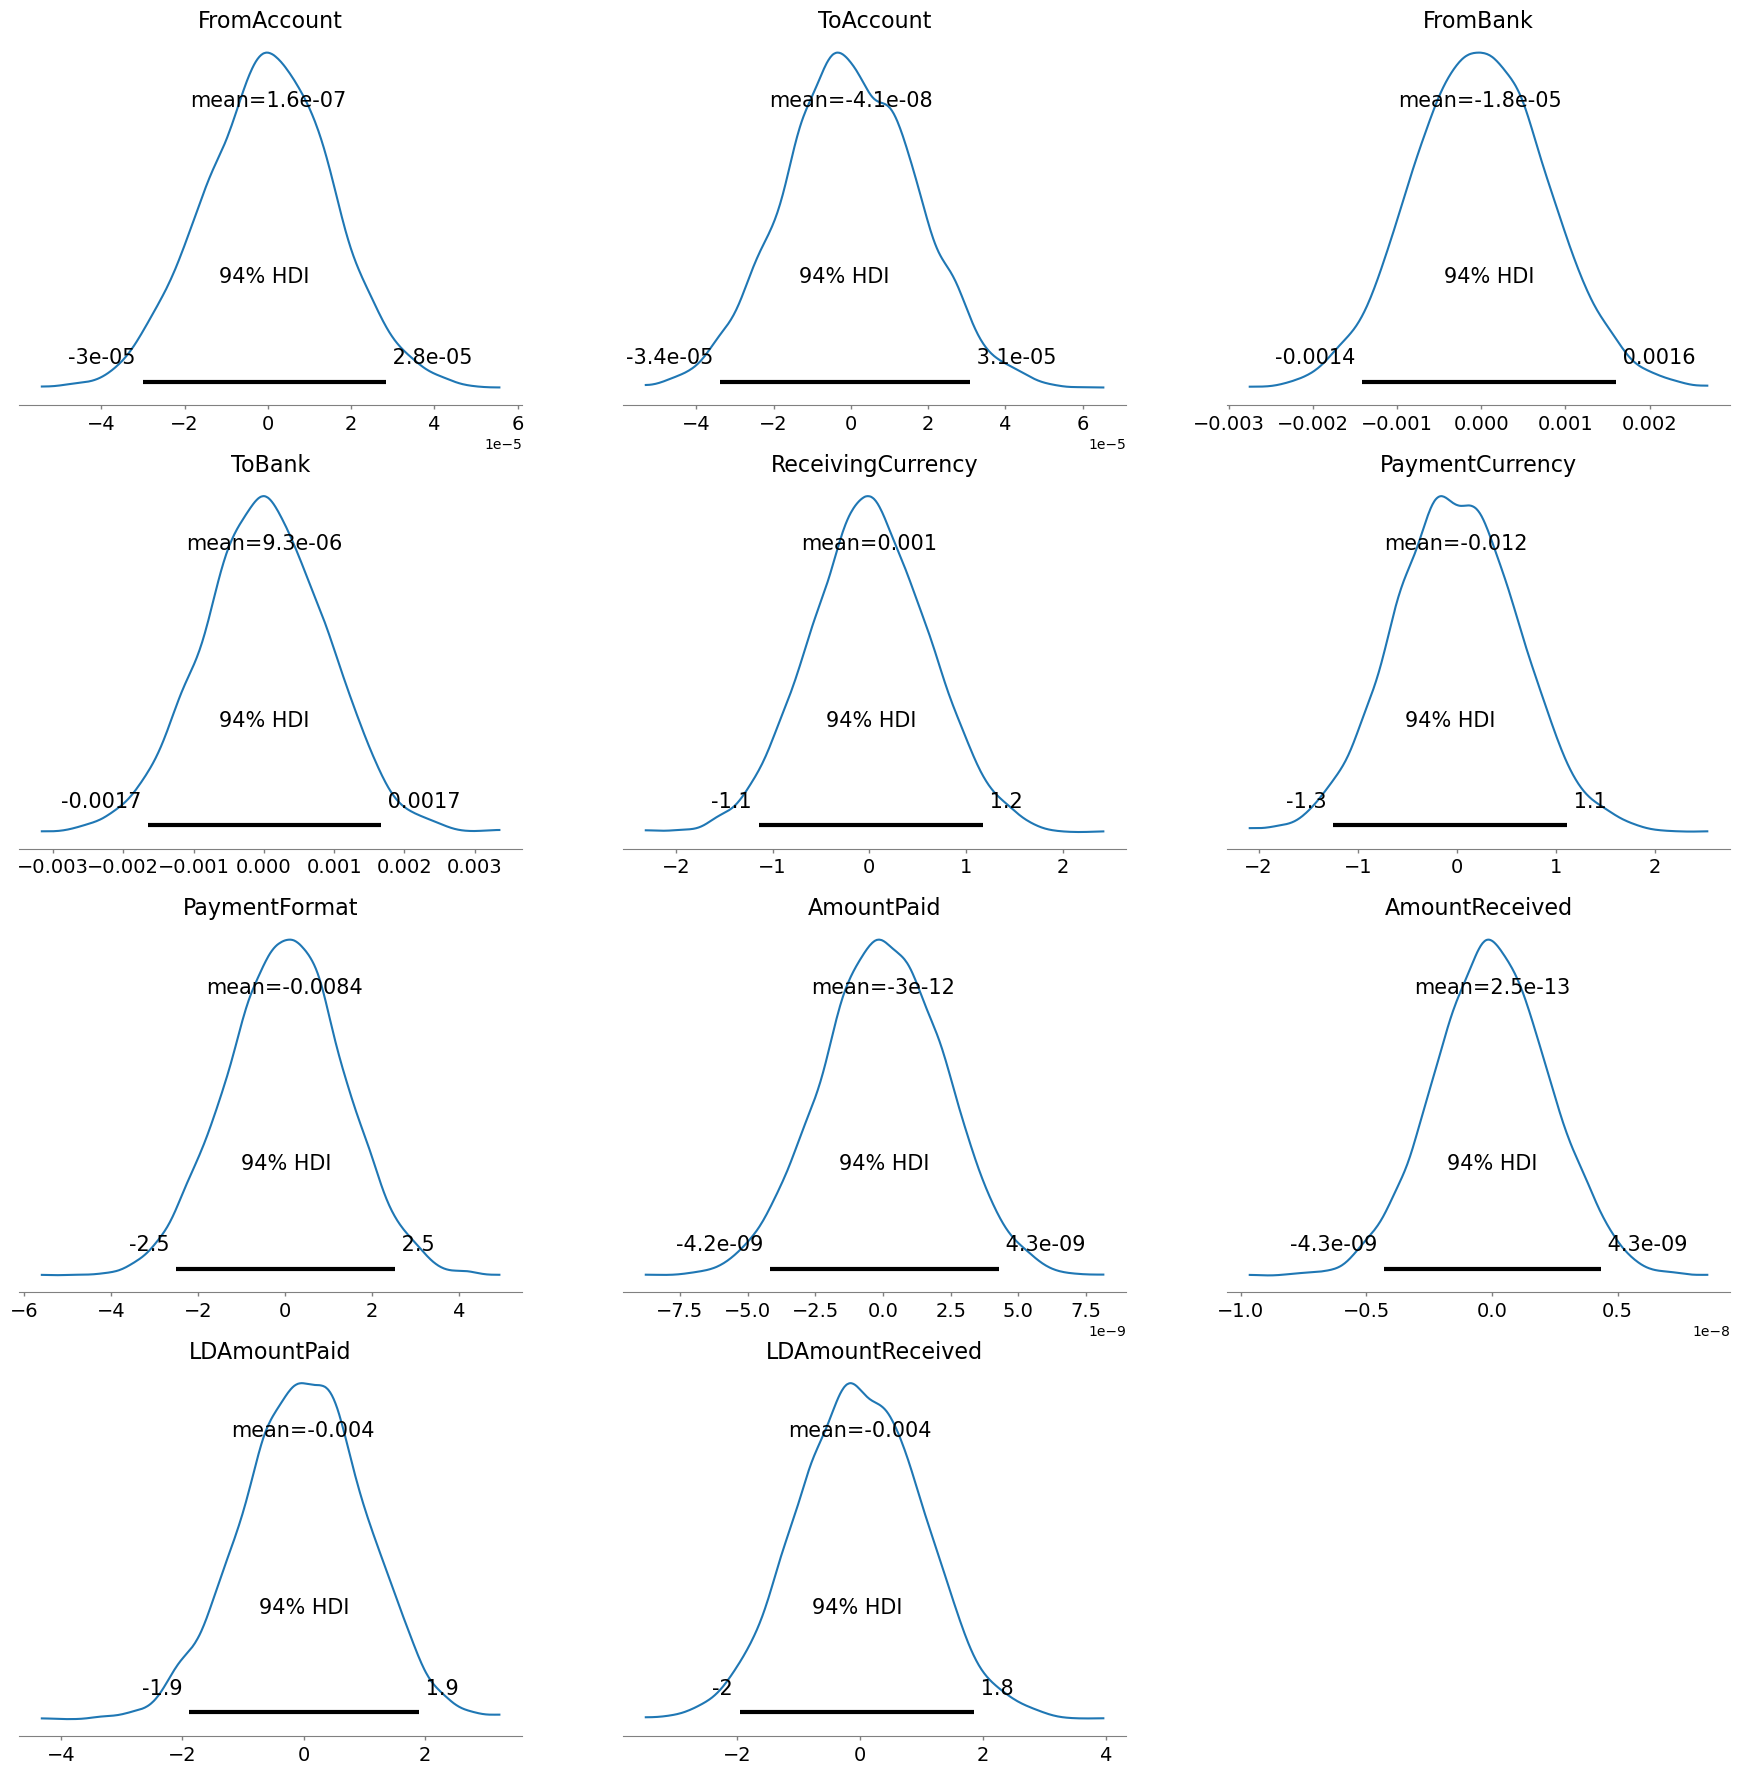

In [ ]:
# Plot marginal priors of the built model
model2.build()
model2.plot_priors()

In [ ]:
# fit the model
results2 = model2.fit(draws=1000, chains=2, inference_method='nuts_blackjax', idata_kwargs={"log_likelihood": True})

Modeling the probability that IsLaundering==1
Compiling...
Compilation time = 0:00:00.514251
Sampling...
Sampling time = 0:00:09.378514
Transforming variables...
Transformation time = 0:00:00.065740
Computing Log Likelihood...
Log Likelihood time = 0:00:00.461480


### Model Comparison

In [ ]:
models_dict = {
    "model": results,
    "model2": results2
}
df_compare = az.compare(models_dict)
df_compare

/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:1024: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/home/bernard/miniconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work wel

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model,0,-349681.753098,321787.770686,0.000000,0.865115,2.075313e+03,0.000000,True,log
model2,1,-362554.791675,355445.874191,12873.038577,0.134885,7.195802e-13,2075.313253,True,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

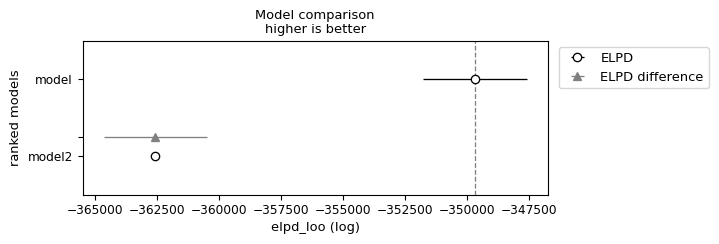

In [ ]:
az.plot_compare(df_compare, insample_dev=False)

### Run inference

In [ ]:
array = results.posterior["PaymentCurrency"].as_numpy()
array.shape

(2, 1000)

<Axes: >

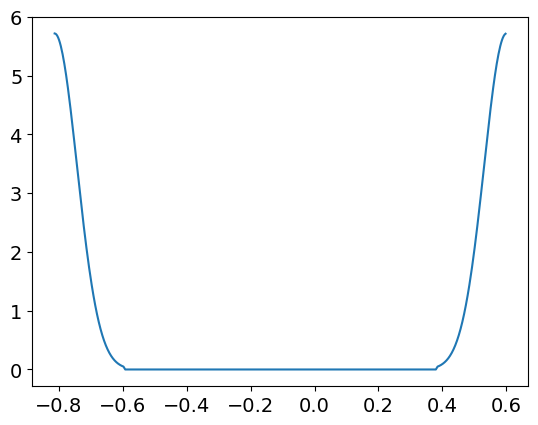

In [ ]:
az.plot_dist(results.posterior["PaymentCurrency"])

<Axes: >

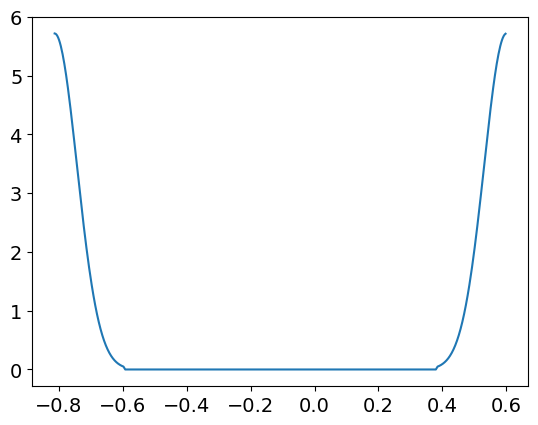

In [ ]:
az.plot_dist(array)

### Model Prediction

(<Figure size 1200x500 with 4 Axes>,
 array([<Axes: title={'center': 'PaymentFormat = 0'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>,
        <Axes: title={'center': 'PaymentFormat = 1'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>,
        <Axes: title={'center': 'PaymentFormat = 3'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>,
        <Axes: title={'center': 'PaymentFormat = 6'}, xlabel='ReceivingCurrency', ylabel='IsLaundering'>],
       dtype=object))

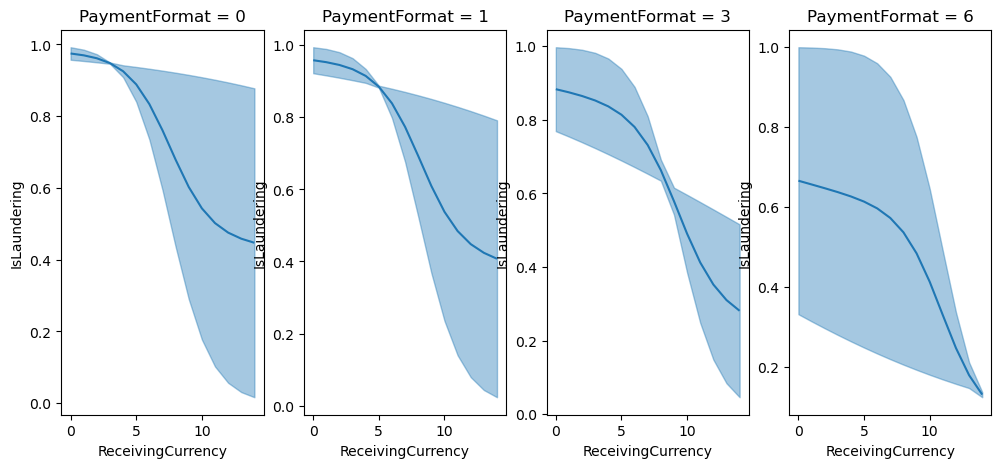

In [ ]:
bmb.interpret.plot_predictions(
    model,
    results,
    ["ReceivingCurrency", "PaymentFormat"],
    subplot_kwargs={"main": "ReceivingCurrency", "group": "LDAmountReceived", "panel": "PaymentFormat"},
    fig_kwargs={"figsize": (12, 5)},
    legend=False
)

In [ ]:
pred_df = bmb.interpret.predictions(
    model,
    results
)

pred_df.head(10)

,AmountPaid,AmountReceived,FromAccount,FromBank,LDAmountPaid,LDAmountReceived,PaymentCurrency,PaymentFormat,ReceivingCurrency,ToAccount,ToBank,estimate,lower_3.0%,upper_97.0%
690970,22134.180000,22134.180000,514607,7,2,2,6,2,6,149072,742,5.000000e-01,2.220446e-16,1.000000e+00
2193338,2025.430000,2025.430000,501340,24,2,2,12,4,12,29496,6047,5.000000e-01,2.220446e-16,1.000000e+00
511277,0.031935,0.031935,233926,46,3,3,1,1,1,61651,35,5.000000e-01,2.220446e-16,1.000000e+00
4986859,3687.580000,3687.580000,190960,831,3,3,12,4,12,503640,51,5.000000e-01,2.220446e-16,1.000000e+00
1599722,5005.460000,5005.460000,41364,629,5,5,4,3,4,125419,702,5.000000e-01,2.220446e-16,1.000000e+00
1101951,78.450000,78.450000,68000,645,7,7,12,4,12,64045,6146,5.000000e-01,2.220446e-16,1.000000e+00
1577862,506.690000,506.690000,439599,294,5,5,12,4,12,177386,0,5.000000e-01,2.220446e-16,1.000000e+00
3091344,2995.660000,2995.660000,501344,24,2,2,7,4,7,23602,6033,5.000000e-01,2.220446e-16,1.000000e+00
4183880,171.440000,171.440000,217755,6542,1,1,11,3,11,48904,6090,5.000000e-01,2.220446e-16,1.000000e+00
3985250,3655.270000,3655.270000,250145,874,3,3,4,4,4,182482,15,1.110223e-16,1.771746e-159,2.220446e-16


In [ ]:
pred_df['estimate'].value_counts()

estimate
5.000000e-01    5003
5.000000e-01    4017
1.000000e+00     842
2.220446e-16     359
1.110223e-16      27
5.000007e-01       1
5.000021e-01       1
8.663627e-01       1
1.110223e-16       1
2.265476e-01       1
1.111527e-01       1
3.519591e-78       1
1.997291e-16       1
Name: count, dtype: int64